# Classification par apprentisage profond avec couches de Dropout

Les couches de dropout serviront à aider le réseau à ne pas surapprendre sur les données d'entraînement.

In [82]:
import numpy
import time

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from matplotlib import pyplot

from tqdm.notebook import tqdm

In [128]:
labeledData = numpy.load('labeled.npy')
numberOfData = labeledData.shape[0] # 1441
dimensions = labeledData.shape[1] # 1183

# normaliser les données d'entrée entre 0 et 1 pour toutes les dimensions.
X_train = minmax_scale(labeledData[ : -((numberOfData//4)), :]) # 1081 premières données
X_test = minmax_scale(labeledData[(numberOfData//4)*3 + 1 : ,  :]) # 360 dernières données

# Définition de fonctions utilitaires

In [84]:
def create_balanced_sampler(dataset):
    def make_weights_for_balanced_classes(images, n_classes):                        
        count = [0] * n_classes                                                      
        for item in images:                                                         
            count[int(item[1])] += 1                                                     
        weight_per_class = [0.] * n_classes                                      
        N = float(sum(count))                                                   
        for i in range(n_classes):                                                   
            weight_per_class[i] = N/float(count[i])                                 
        weight = [0] * len(images)                                              
        for idx, val in enumerate(images):                                          
            weight[idx] = weight_per_class[int(val[1])]                                  
        return weight

    n_classes = numpy.unique(dataset.targets)
    weights = make_weights_for_balanced_classes(dataset.data, len(n_classes))                                                         
    weights = torch.DoubleTensor(weights)                 
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 
    return sampler

def compute_accuracy(model, dataloader, device='cpu'):
    training_before = model.training
    model.eval()
    all_predictions = []
    all_targets = []
    
    for i_batch, batch in enumerate(dataloader):
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = model(images)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    if all_predictions[0].shape[-1] > 1:
        predictions_numpy = numpy.concatenate(all_predictions, axis=0)
        predictions_numpy = predictions_numpy.argmax(axis=1)
        targets_numpy = numpy.concatenate(all_targets, axis=0)
    else:
        predictions_numpy = numpy.concatenate(all_predictions).squeeze(-1)
        targets_numpy = numpy.concatenate(all_targets)
        predictions_numpy[predictions_numpy >= 0.5] = 1.0
        predictions_numpy[predictions_numpy < 0.5] = 0.0

    if training_before:
        model.train()

    return (predictions_numpy == targets_numpy).mean()

# Définition du Dataset
Définition de la classe RAMQDataset, une classe qui hérite de la classe abstraite torch.utils.data.Dataset. Comme mentionné dans la documentation, les méthodes getitem et len sont surchargées afin d'avoir un jeu de données utilisable par PyTorch. Le data accepté en paramètres est un array numpy dont la dernière dimension est la valeur de l'étiquette.

In [107]:
class RAMQDataset(Dataset):
    """
    Cette classe sert à définir le dataset RAMQ pour PyTorch
    """

    def __init__(self, data):
        super().__init__()
        self.data = []
        for elem in data:
            if isinstance(elem, numpy.ndarray):
                elem = elem.tolist()
                elem_data = torch.Tensor(elem[:-1])
                elem_target = torch.FloatTensor([elem[-1]])
            # garde les paramètres en mémoire
            self.data += [(elem_data, elem_target[0])]
            
        self.targets = numpy.array(data[:, -1])

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)
    
    def dim(self):
        return len(self.data[0][0])

# Définition d'un réseau de neurones multicouche linéaire avec Dropout

In [108]:
class RAMQNet(nn.Module):
    """
    Cette classe définit un réseau permettant de classifier des données de la RAMQ
    """

    def __init__(self, n_inputs, n_layers, drop_ratio = 0.5, activation = nn.ELU()):
        super().__init__()
        
        reduction_ratio = (1/n_inputs)**(1/n_layers)
        
        layers = []
        layer_lenght = n_inputs
        
        # Calculate nb of layers and nb of neurons
        # Builds a list (ex:[1000, 500, 250, ... until 1])
        while layer_lenght > 1:
            layers.append(layer_lenght)
            layer_lenght = int(layer_lenght*reduction_ratio)
        layers.append(1)
        
        # Build network layers
        network_layers = []
        for i, n_neurons in enumerate(layers[:-1]):
            layer = nn.Linear(layers[i], layers[i+1])
            network_layers.append(nn.Dropout(p=drop_ratio))
            network_layers.append(layer)
            network_layers.append(activation)
            network_layers.append(nn.BatchNorm1d(layers[i+1]))
        network_layers[-1] = nn.Sigmoid()
            
        # Build pytorch sequential network
        self.network = nn.Sequential(
            *network_layers
        )
        
    def forward(self, x):

        # Exécute l'inférence du réseau. L'ordre 
        # d'exécution ici est important.
        x = self.network(x)
        
        return x

## 5. Déclaration de la fonction permettant l'affichage du pourcentage d'efficacité en classement selon 1 à 9 couches d'un réseau de neurones "x"
Cette méthode n'a besoin, en entrées, que d'un tableau des pourcentages d'efficacité pour 0 à 9 couches.

In [109]:
def plot_results(test_accu):
    fig = pyplot.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(test_accu, label='Test accuracy')
    ax.set_xlim(1, 9)
    pyplot.grid()

    pyplot.show()

## 6. Déclaration de la fonction permettant la classification par réseau de neurones profond
Cette méthode n'a besoin, en entrées, que des jeux d'entraînement et de test normalisé, dont la dernière dimension de chaque donnée constitue la valeur de l'étiquette reliée. 

In [126]:
def compute_results(X_train, X_test):
    # Définit si cuda est utilisé ou non
    # mettre cuda pour utiliser un GPU
    device = "cpu" #if torch.cuda.is_available() else "cpu"

    # Définit les paramètres d'entraînement 
    nb_epoch = 250
    learning_rate = 0.01
    momentum = 0.9
    batch_size = 32

    # Charge les données d'entraînement et de test
    train_set = RAMQDataset(X_train)
    test_set = RAMQDataset(X_test)
    n_dim = train_set.dim()

    # Crée le sampler avec les classes balancées
    balanced_train_sampler = create_balanced_sampler(train_set)
    balanced_test_sampler = create_balanced_sampler(test_set)

    # Crée le dataloader d'entraînement
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=balanced_train_sampler)
    test_loader = DataLoader(test_set, batch_size=batch_size, sampler=balanced_test_sampler)

    test_accu = []
    test_accu.append(0)

    # Instancier un réseau RAMQNet
    # dans une variable nommée "model"
    n_layers = range(1,10)
    ratio = 0.1
    print('Drop ratio ' + str(ratio))
    for i in tqdm((n_layers), desc='Nombre de couches explorées'):
        model = RAMQNet(n_dim, i, drop_ratio=ratio)

        # Tranfert le réseau au bon endroit
        model.to(device)

        # Instancier une fonction d'erreur BinaryCrossEntropy
        # et la mettre dans une variable nommée criterion
        criterion = nn.BCELoss()

        # Instancier l'algorithme d'optimisation SGD
        # Ne pas oublier de lui donner les hyperparamètres
        # d'entraînement : learning rate et momentum!
        optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)

        # Mettre le réseau en mode entraînement
        model.train()
        for i_epoch in tqdm(range(nb_epoch), desc='Progrès pour {} couches'.format(i), leave=False):
            start_time, train_losses = time.time(), []
            for i_batch, batch in enumerate(train_loader):
                values, targets = batch
                targets = targets.type(torch.FloatTensor).unsqueeze(-1)

                values = values.to(device)
                targets = targets.to(device)

                # Mettre les gradients à zéro
                optimizer.zero_grad()

                # Calculer:
                # 1. l'inférence dans une variable "predictions"
                # 2. l'erreur dans une variable "loss"
                predictions = model(values)
                loss = criterion(predictions, targets)

                # Rétropropager l'erreur et effectuer
                # une étape d'optimisation
                loss.backward()
                optimizer.step()

                # Ajoute le loss de la batch
                train_losses.append(loss.item())

        # affiche le score à l'écran
        test_acc = compute_accuracy(model, test_loader, device)
        test_accu.append(test_acc)
    plot_results(test_accu)
    print(test_accu)

Drop ratio 0.1


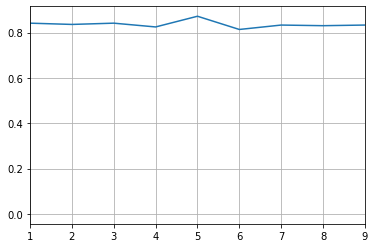

[0, 0.8416666666666667, 0.8361111111111111, 0.8416666666666667, 0.825, 0.8722222222222222, 0.8138888888888889, 0.8333333333333334, 0.8305555555555556, 0.8333333333333334]


In [74]:
compute_results(X_train, X_test) # all dimensions

## Notes sur les observations (dropout aux deux couches)
La première fois, avec 20\% de dropout à chaque deux couches, on a réussi à obtenir 90\% de taux de classement pour 6 couches. Les résultats variaient entre 85\% et 90\% qui est 5\% plus élevé que les résultats sur couches linéaires seulement.

Avec 50\% de dropout, on retrouve à peu près des performances entre 80\% et 86\%, ce qui semble moins concluant.

Les essais avec 10\% montrent une variation entre 80\% et 88\% de taux de succès.

Y a-t-il vraiment une influence avec le taux de dropout? Les résultats semblent montrer que non.

## Notes sur les observations (dropout à chaque couche)
Essayons avec du dropout de 20%, mais pour toutes les couches du modèle. On obtient une variation entre 82\% et 89\% pour le taux de succès.

Avec un dropout de 50\%, on obtient une variation entre 78\% et 88\% pour le taux de succès.

Avec un dropout de 10\%, on obtient une variation entre 82\% et 87\% pour le taux de succès.

Les résultats semblent indiquer que le dropout n'aide pas dans le cas où on a toutes les dimensions sur les données

# Exploration avec des données à dimensionnalité réduite
On commence avec le jeu de données réfuit à 500 dimensions (au lieu de 1182)

In [124]:
less_dim_labeledData = numpy.load('labeled_reduit_100dim.npy')
numberOfData = less_dim_labeledData.shape[0] # 1441
dimensions = less_dim_labeledData.shape[1] # 101

# normaliser les données d'entrée entre 0 et 1 pour toutes les dimensions.
X_train_less_dim = minmax_scale(less_dim_labeledData[ : -((numberOfData//4)), :]) # 1081 premières données
X_test_less_dim = minmax_scale(less_dim_labeledData[(numberOfData//4)*3 + 1 : ,  :]) # 360 dernières données

Drop ratio 0.1


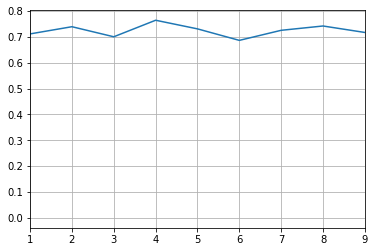

[0, 0.7111111111111111, 0.7388888888888889, 0.7, 0.7638888888888888, 0.7305555555555555, 0.6861111111111111, 0.725, 0.7416666666666667, 0.7166666666666667]


In [127]:
compute_results(X_train_less_dim, X_test_less_dim) # less dimensions